In [1]:
from __future__ import division
import sys

sys.path.append("../")
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.distributions.multivariate_normal import MultivariateNormal
import os
from src.sampling import (
    MonteCarloSampler,
    stdG,
    StochasticAllenCahn,
    StochasticAllenCahn1D,
    StochasticAllenCahn1D_base,
)
from src.RNVP import stacked_NVP
from src.MCMC_w_flow import MCMC_w_flow

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Plotting

In [27]:
def view(losses, acc_probs):
    plt.plot(losses)
    plt.title("Model Loss vs Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    plt.plot(acc_probs)
    plt.title("Acceptance probability vs Number of Resampling Steps")
    plt.xlabel("Number of Resampling Steps")
    plt.ylabel("Acceptance Probability")
    plt.show()


## Application I: Gaussian mixtures

In [17]:
def bimodal_gaussian(x):
    norm_1 = torch.linalg.norm(x - torch.Tensor([5, 0])).detach()
    norm_2 = torch.linalg.norm(x - torch.Tensor([-5, 0])).detach()
    return -torch.log(2 * torch.exp(-0.5 * norm_1 ** 2) + torch.exp(-0.5 * norm_2 ** 2))

In [68]:
nwalkers = 40
base = stdG(d=2)
model_bimodal = stacked_NVP(
    d=2, k=1, hidden=200, n=4, depth=2, base_dist=base, batch_norm=False
)
walker = [
    MonteCarloSampler(dim=2, energy_fn=bimodal_gaussian, step_size=0.03)
    for i in range(nwalkers)
]
optim = torch.optim.Adam(model_bimodal.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, 0.999)
init_pos = torch.stack(
    [torch.Tensor([5, 0]) for i in range(20)]
    + [torch.Tensor([-5, 0]) for i in range(20)]
)

# training loop
bimodal_G = MCMC_w_flow(
    model_bimodal,
    walker,
    1000,
    init_pos,
    optim=optim,
    scheduler=scheduler,
    base_dist=base,
    burnin=2000,
    batch_size=10,
    save_dir="bimodal_gaussian.pth",
    threshold=0.85,
)

In [69]:
bimodal_G.train()

In [70]:
checkpoint_file = "bimodal_gaussian.pth"
if os.path.exists(checkpoint_file):
    checkpoint = torch.load(checkpoint_file)
    model_bimodal.load_state_dict(checkpoint["model"])
    optim.load_state_dict(checkpoint["optim"])
    losses = torch.Tensor(checkpoint["losses"]).detach().numpy()
    acc_probs = torch.Tensor(checkpoint["acc_probs"]).detach().numpy()

In [74]:
view(losses, acc_probs)


def bimodal_analytical(n_samples=10000):
    base_mu, base_cov = torch.Tensor([-5, 0]), torch.eye(2)
    base_dist = MultivariateNormal(base_mu, base_cov)
    X = base_dist.rsample(sample_shape=(n_samples,))
    base_mu = torch.Tensor([5, 0])
    base_dist = MultivariateNormal(base_mu, base_cov)
    X = torch.cat([X, base_dist.rsample(sample_shape=(2 * n_samples,))])
    return X

Z = base.get_samples(10000)
X_hat = model_bimodal.inverse(Z)[0].detach().numpy()
plt.hist2d(X_hat[:, 0], X_hat[:, 1], 100, [[-10, 10], [-10, 10]],density=True)
plt.title(r"Inverse of Normal Samples Z: $X = F^{-1}(Z)$")
plt.colorbar()
plt.show()

n_samples = 10000
X = bimodal_analytical(n_samples=n_samples)

plt.hist2d(X.numpy()[:, 0], X.numpy()[:, 1], 100, [[-10, 10], [-10, 10]],density=True)
plt.title("Reference Target Density")
plt.colorbar()
plt.show()

z, _ = model_bimodal(X)
z = z.detach().numpy()
plt.hist2d(z[:, 0], z[:, 1], 100, [[-4, 4], [-4, 4]], density=True)
plt.colorbar()
plt.title("Transformation of Data Samples X: Z = F(X)")
plt.show()

tensor([0.7596], grad_fn=<AddBackward0>)
tensor([-0.7596], grad_fn=<AddBackward0>)


## Application II: Free Energy Calculation of FCC LJ Solids

---Generating data---

1) Run a direct molecular dynamics simulation on a lattice LJ system. Collect the trajectory containing lattice coordinates and potential energies.

---Training neural net---

2) Initialization: I used an RNVP with 2 coupling layers. For the neural networks in each coupling layer, I used MLP with depth 2 and 600 neurons.

3) For each iteration, draw samples from the trajectory, use the normalizing flow to transform them into the base measure (p_z), and then maximize the push-forward probability p_x=p_z+log_Jacob.

---Evaluating---

4) Caculate the absolute free energy based on the learned probabiltiy distribution.(Future: draw samples from the base distribution, push-forward and compute the free energy difference using the BAR method)

5) It seems that now the normalizing flow is overestimating the free energy: -1.98 kT compared to -1.58 kT from Fenkel Ladd. 

---To do---

1) Inspect the RNVP: the loss should go further down.

2) Implement the BAR method to get free energy estimation.

3) Fix the deprecated batch normalization.

4) Hard-code less stuff.

In [4]:
n=256
kB = 8.6173*10e-5
T=10
beta=1/(kB*T)
base=stdG(3*n)  #standard Gaussian
nf=torch.load("../saved_models/lj.pth")
model_lj = stacked_NVP(3*n,3*128,hidden=600,n=2,depth=2,base_dist=base,batch_norm=False)
model_lj.load_state_dict(nf["model"])
losses=torch.Tensor(nf["losses"]).detach().numpy()

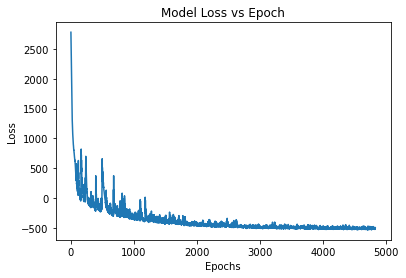

In [5]:
plt.plot(losses)
plt.title("Model Loss vs Epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

## Application III: 1D/ 2D Stochastic Allen Cahn

In [ ]:
ac1d = [StochasticAllenCahn1D(100) for i in range(100)]
init_pos = torch.cat((1 - torch.rand((50, 100)) ** 2, torch.rand((50, 100)) ** 2 - 1))
# init_pos = torch.cat((torch.ones((50, 100)), -torch.ones((50, 100))))
base = StochasticAllenCahn1D(100)
model_ac1d = stacked_NVP(100, 50, hidden=200, n=6, base_dist=base, batch_norm=True)
optim = torch.optim.Adam(model_ac1d.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, 0.999)
AC1d = MCMC_w_flow(
    model_ac1d,
    ac1d,
    100,
    init_pos,
    optim=optim,
    scheduler=scheduler,
    base_dist=base,
    burnin=5000,
    k_lang=1,
    batch_size=10,
    threshold=0.5,
    save_dir="saved_models/AC1d_best.pth",
)
AC1d.train()

In [350]:
base = stdG(100)
# init_pos = torch.cat((torch.ones((50, 100)), -torch.ones((50, 100))))
# init_pos = torch.cat((1 - torch.rand((50, 100)) ** 2, torch.rand((50, 100)) ** 2 - 1))
ac_system = [
    StochasticAllenCahn(10, beta=10, h=0.1, step_size=0.001) for i in range(50)
]
model_ac = stacked_NVP(
    100, 50, hidden=200, n=6, base_dist=base, batch_norm=True, init_std=1e-3
)
optim = torch.optim.Adam(model_ac.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, 0.999)

<IPython.core.display.Javascript object>

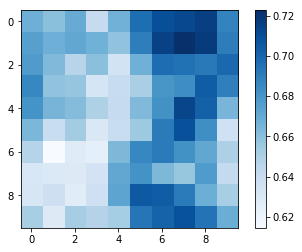

<IPython.core.display.Javascript object>

In [354]:
init_pos = torch.load("../saved_models/AC_starting_pos_50.pth")
plt.imshow(init_pos[0].view(10, 10).numpy(), cmap="Blues")

plt.colorbar()
plt.show()
AC = MCMC_w_flow(
    model_ac,
    ac_system,
    1000,
    init_pos,
    optim=optim,
    scheduler=scheduler,
    base_dist=base,
    burnin=1000,
    k_lang=4,
    batch_size=10,
)

In [ ]:
AC.train()

## Misc

In [ ]:
def generate_samples(model, nsamples, burnin=10000):
    for i in range(nsamples + burnin):
        model.sample_step(record=(i >= burnin))


ac = StochasticAllenCahn(10, beta=10, h=0.1, D=1, step_size=0.001)
# init_pos = torch.ones(100)
# init_pos = torch.rand((100,)) ** 2 - 1
init_pos = torch.load("../saved_models/AC_starting_pos_2.pth")[0]
print(ac.compute_energy(init_pos))
ac.initialize(init_pos)

generate_samples(ac, 2000, burnin=0)

print(torch.mean(ac.samples))
plt.plot(ac.samp_energy)
plt.show()
plt.imshow(ac.x.view(10, 10).numpy(), cmap="Blues")
plt.colorbar()
plt.show()